In [193]:
import numpy as np
import sys
sys.path.append('../')
from utils import *
from processing import *
import matplotlib.pyplot as plt
import h5py
from scipy.stats import median_abs_deviation as mad

In [3]:
out_dir = '../output'
path_file = './file_dir_coronal_sparse.json'

sampled_coord_path = '../sampled_Imaging_20210419_Coronal_sparse0.4.xml'
tissue_coord_path = '../Imaging_20210419_Coronal_sparse0.4.xml'
sampled_coords = parse_coords(sampled_coord_path)
tissue_coords = parse_coords(tissue_coord_path)

import json
with open(path_file, 'r') as fp:
    path_dict = json.load(fp)
params = getParams(path_dict['parameter_data_path'])
params_basis = getParams(path_dict['parameter_basis_path'])
data_imaging_info = parseImagingInfo(path_dict['data_imaging_info'])
basis_imaging_info = parseImagingInfo(path_dict['basis_imaging_info'])

In [4]:
print('data parameters:',params)
print('basis parameters:',params_basis)
print('data imaging information:',data_imaging_info)

data parameters: {'parameters': {'SW_h': 714285.7142857143, 'TD': 65536, 'ML1': 107798997.08328888, 'ML2': 5.694034141537156, 'ML3': 0.0}, 'T': 7e-07, 't': array([0.00000e+00, 7.00000e-07, 1.40000e-06, ..., 4.58731e-02,
       4.58738e-02, 4.58745e-02]), 'f': array([1.00000000e-01, 2.17982701e+01, 4.35965402e+01, ...,
       7.14242118e+05, 7.14263916e+05, 7.14285714e+05]), 'm': array([1.86051712e+07, 3.92106082e+06, 2.18701037e+06, ...,
       1.50926605e+02, 1.50921999e+02, 1.50917393e+02])}
basis parameters: {'parameters': {'SW_h': 714285.7142857143, 'TD': 1048576, 'ML1': 107798997.08328888, 'ML2': 5.694034141537156, 'ML3': 0.0}, 'T': 7e-07, 't': array([0.000000e+00, 7.000000e-07, 1.400000e-06, ..., 7.340011e-01,
       7.340018e-01, 7.340025e-01]), 'f': array([1.00000000e-01, 1.36239188e+00, 2.72478376e+00, ...,
       7.14282990e+05, 7.14284352e+05, 7.14285714e+05]), 'm': array([1.86051712e+07, 1.52767133e+07, 1.28045289e+07, ...,
       1.50917969e+02, 1.50917681e+02, 1.50917393e

In [525]:
mz_range = (400,1000)
mz = params['m'][(params['m']>mz_range[0])&(params['m']<mz_range[1])]
average_sp = np.zeros(mz.shape)

with h5py.File('../output/coronal_40perc/data.h5','r') as data_file:
    for i in tqdm(range(len(sampled_coords))):
        fid =  np.array(data_file[str(i)].get('transient'))
        _, sp = fid2spec(fid, params['m'], mz_range=(400,1000))
        average_sp += np.sum(sp,0)
average_sp = average_sp/sampled_coords.shape[0]

Text(0, 0.5, 'intensity')

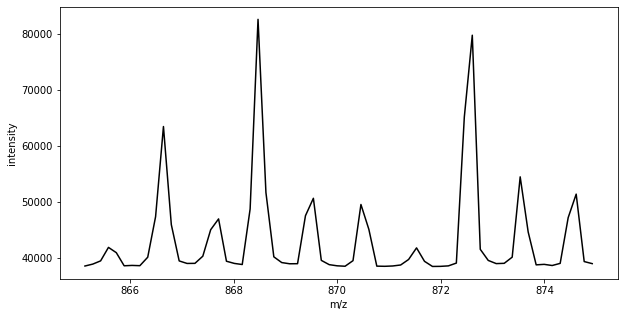

In [485]:
mz_filter = (mz>865)&(mz<875)
plt.figure(figsize=(10,5))
plt.plot(mz[mz_filter], average_sp[mz_filter],c='k')
plt.xlabel('m/z')
plt.ylabel('intensity')

Text(0, 0.5, 'intensity')

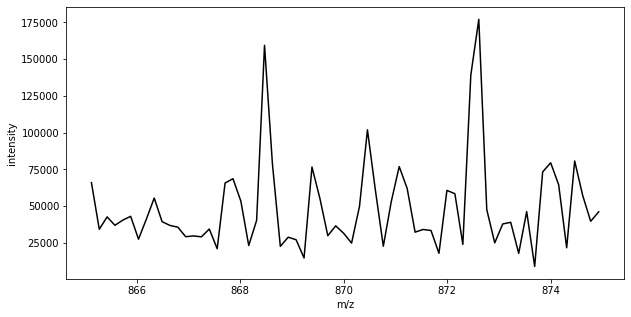

In [507]:
idx = 21127
with h5py.File('../output/coronal_40perc/data.h5','r') as data_file:
    fid =  np.array(data_file[str(idx)].get('transient'))
    mz, sp = fid2spec(fid, params['m'], mz_range=(400,1000))
    
mz_filter = (mz>865)&(mz<875)
plt.figure(figsize=(10,5))
plt.plot(mz[mz_filter], sp[0][mz_filter],c='k')
plt.xlabel('m/z')
plt.ylabel('intensity')

In [139]:
mzs_use = peak_detection(mz,average_sp,mad(average_sp), mad(average_sp))['mz']

peak_data = []
with h5py.File('../output/coronal_40perc/data.h5','r') as data_file:
    for i in tqdm(range(len(sampled_coords))):
        fid =  np.array(data_file[str(i)].get('transient'))
        mz, sp = fid2spec(fid, params['m'], mz_range=(400,1000))
        peak_data.append(sp[:,np.in1d(mz, mzs_use)])
peak_data = np.concatenate(peak_data)

100%|███████████████████████████████████████████████████████████████████████████| 33905/33905 [02:22<00:00, 237.66it/s]


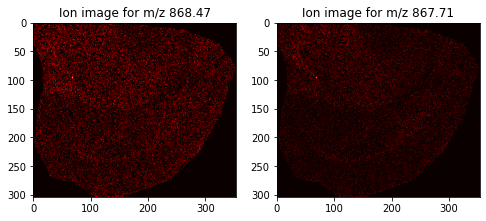

In [570]:
mz_idx = [58,59]
fig,axes = plt.subplots(1,2,figsize=(8,4))
ax = axes.ravel()
for i,idx in enumerate(mz_idx):
    ion_img = IonImg(peak_data[:,idx]/peak_data.sum(1),sampled_coords,True, False)
    ax[i].imshow(ion_img,'hot')
    ax[i].set_title('Ion image for m/z {}'.format(np.round(mzs_use[idx],2)))
plt.show()

Text(0, 0.5, 'intensity')

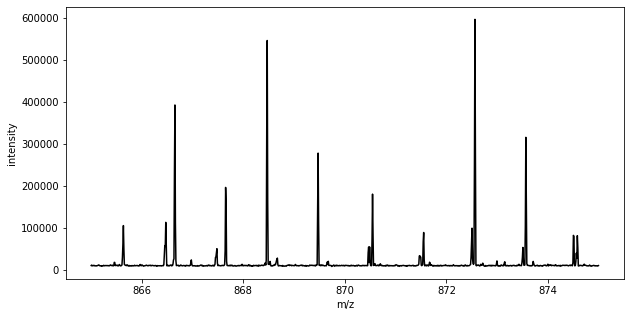

In [526]:
average_sp_recon = np.load('../output/coronal_40perc/avgspec_recon.npy')
mz_recon = params_basis['m'][(params_basis['m']>mz_range[0])&(params_basis['m']<mz_range[1])]

mz_filter = (mz_recon>865)&(mz_recon<875)
plt.figure(figsize=(10,5))
plt.plot(mz_recon[mz_filter], average_sp_recon[mz_filter],c='k')
plt.xlabel('m/z')
plt.ylabel('intensity')

In [527]:
spatial_coef = np.load('../output/coronal_40perc/updatedU.npy')
V_hat = np.load('../output/coronal_40perc/basis_transients.npy')

Text(0, 0.5, 'intensity')

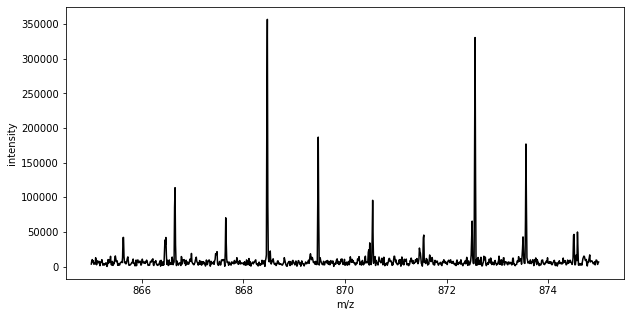

In [528]:
idx = 62310
fid_recon = spatial_coef[idx].dot(V_hat)
mz_recon,sp_recon = fid2spec(fid_recon,params_basis['m'],mz_range=(700,900))

mz_filter = (mz_recon>865)&(mz_recon<875)
plt.figure(figsize=(10,5))
plt.plot(mz_recon[mz_filter], sp_recon[mz_filter],c='k')
plt.xlabel('m/z')
plt.ylabel('intensity')

In [529]:
with open('../output/coronal_40perc/peakdata_recon.pkl', 'rb') as f:
    peak_data_recon = pickle.load(f)

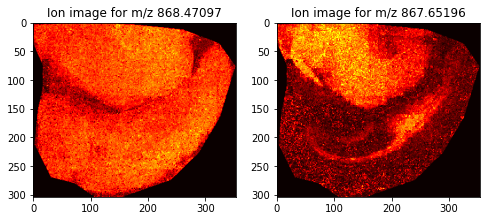

In [550]:
mz_idx = [341,344]
fig,axes = plt.subplots(1,2,figsize=(8,4))
ax = axes.ravel()
for i,idx in enumerate(mz_idx):
    ion_img = IonImg(peak_data_recon['intens_mtx'][:,idx]/peak_data_recon['intens_mtx'].sum(1),tissue_coords,True,False)
    ax[i].imshow(ion_img,'hot')
    ax[i].set_title('Ion image for m/z {}'.format(np.round(peak_data_recon['mz'][idx],5)))
plt.show()